In [1]:
import torch
import torch.nn as nn

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False 
}


In [2]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        # optional trainable params
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True) # (batch,1)
        # biased variance: divided by 1/(n-1)
        # unbiased variance: divided by 1/n
        var = x.var(dim=-1, keepdim=True, unbiased=False) # (batch,1)
        norm_x = (x-mean) / torch.sqrt(var+self.eps) # (batch,emb_dim)
        return self.scale * norm_x + self.shift # (batch,emb_dim)
        

class GeLU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5*x*(1+torch.tanh( torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.044715*torch.pow(x,3)) ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            GeLU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
        )
    
    def forward(self, x):
        return self.layers(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        self.d_out = d_out # 4
        self.num_heads = num_heads # 2
        self.head_dim = d_out // num_heads # 2
        
        # bigger weight matrices
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias) # (3,4)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias) # (3,4)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias) # (3,4)
        
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        
        # compute big kqv matrices
        keys = self.W_key(x) # (b,n,3)=>(b,n_token,4)
        queries = self.W_query(x) # (b,n,3)=>(b,n_token,4)
        values = self.W_value(x) # (b,n,3)=>(b,n_token,4)
        # ... then splits
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) # (b,n_token,n_head=2,head_dim=2)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim) # (b,n_token,n_head,head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim) # (b,n_token,n_head,head_dim)
        # swap <num_heads> to after-batch location
        keys = keys.transpose(1,2) # (b,n_head=2,n_token,head_dim=2)
        queries = queries.transpose(1,2) # (b,n_head=2,n_token,head_dim=2)
        values = values.transpose(1,2) # (b,n_head=2,n_token,head_dim=2)

        attn_scores = queries @ keys.transpose(2,3) # (b,n_head,n_token,head_dim)@(b,n_head,head_dim,n_token)=>(b,n_head,n_token,n_token)
        mask_bool = self.mask.bool()[:num_tokens,:num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf) # (n,n) with upper-right is -inf
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights) # (b,n_head,n_token,n_token)

        context_vec = (attn_weights @ values).transpose(1,2) # (b,n_head,n_token,head_dim=2)=>transpose to (b,n_token,n_head,head_dim=2)
        context_vec = context_vec.contiguous().view(b,num_tokens,self.d_out) # (b,n_token,n_head*head_dim)=(b,n_token,4)
        context_vec = self.out_proj(context_vec) # (b,n_token,4)

        return context_vec # (b,n_token,4)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut 

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut 
        return x 

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        # in_idx: (batch,seq_len), each element is a token-index (integer shows location)
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx) # (batch,seq_len)=>(batch,seq_len,emb_dim)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device)) # (1,seq_len)=>(1,seq_len,emb_dim)
        x = tok_embeds + pos_embeds # (batch,seq_len,emb_dim)
        x = self.drop_emb(x) # (batch,seq_len,emb_dim)
        x = self.trf_blocks(x) # (batch,seq_len,emb_dim)
        x = self.final_norm(x) # (batch,seq_len,emb_dim)
        logits = self.out_head(x) # (batch,seq_len,vocab_len)
        return logits

In [3]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## Use GPT to generate text

In [4]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx: (batch, n_tokens_long)
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:] # take last <context_size> tokens as context => (batch,context_size)
        with torch.no_grad():
            logits = model(idx_cond) # (batch,context_size,vocab_len)
        logits = logits[:,-1,:] # last tokenS - (batch,vocab_len)
        probas = torch.softmax(logits,dim=-1) # (batch,vocab_len)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) # (batch,1)
        idx = torch.cat((idx, idx_next), dim=1) #(batch,n_tokens_long+1)
    return idx

In [5]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'}) # (n_tokens,)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # (1,n_tokens)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # (n_tokens,)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
# token_ids: (batch, n_tokens+1)
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


## Text generation loss

In [6]:
inputs = torch.tensor([[16833,3626,6100], # ["every effort moves"
                       [40,1107,588]]) # "I really like"]
targets = torch.tensor([[3626, 6100, 345], # ["effort moves you",
                        [1107,588,11311]]) # "really like chocolate"]
with torch.no_grad():
    logits = model(inputs) # (batch,n_tokens,len_vocab)=(2,3,50257)
probas = torch.softmax(logits, dim=-1) # (batch,n_tokens,len_vocab)=(2,3,50257)
print(probas.shape)

torch.Size([2, 3, 50257])


In [7]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True) # (2,3,1)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [8]:
# Check output after convert back to text
print(f"Targets batch1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch1:  effort moves you
Outputs batch1:  Armed heNetflix


In [9]:
# 1st sentence: probs of the 3 correct words
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 1:", target_probas_1)
# 2nd sentence: probs of the 3 correct words
text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [10]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [11]:
avg_log_probas = torch.mean(log_probas)
neg_avg_log_probas = avg_log_probas * -1
print("Cross entropy loss:\n", neg_avg_log_probas)

Cross entropy loss:
 tensor(10.7940)


In [12]:
# NOTE: Pytorch will take ONE-HOT-LOGITS and INTEGER-TARGET
logits_flat = logits.flatten(0,1) # (batch*n_tokens,vocab_len)
targets_flat = targets.flatten() # (batch*n_tokens,)
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("Pytorch cross-entropy:\n", loss)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
Pytorch cross-entropy:
 tensor(10.7940)


## Calculate train & val losses on real book i.e. "The Verdict"

In [13]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20480
Tokens: 5146


In [14]:
train_ratio = 0.90
split_idx = int(train_ratio*len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]
print(train_data[-15:])


ed my 'techniqu


In [15]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt)
        for i in range(0, len(token_ids)-max_length, stride):
            input_chunk = token_ids[i:i+max_length] # (max_length,) - max_length is input dimension
            target_chunk = token_ids[i+1:i+max_length+1] # (max_length,)
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    def __len__(self):
        return len(self.input_ids)
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]
        

def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
    return dataloader 

In [16]:
torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data, batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True, 
    shuffle=True,
    num_workers=0)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [17]:
# Target y is x shift one to the right
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [18]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device) # (batch,n_token)
    logits = model(input_batch) # (batch,n_token,embed_dim)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss

In [19]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i<num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

/home/phm1605/anaconda3/envs/python310/lib/python3.10/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU1 NVIDIA GeForce GT 1030 which is of cuda capability 6.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (7.0) - (12.0)
    
  warnings.warn(
/home/phm1605/anaconda3/envs/python310/lib/python3.10/site-packages/torch/cuda/__init__.py:304: UserWarning: 
    Please install PyTorch with a following CUDA
    configurations:  12.6 following instructions at
    https://pytorch.org/get-started/locally/
    
  warnings.warn(matched_cuda_warn.format(matched_arches))
/home/phm1605/anaconda3/envs/python310/lib/python3.10/site-packages/torch/cuda/__init__.py:326: UserWarning: 
NVIDIA GeForce GT 1030 with CUDA capability sm_61 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_70 sm_75 sm_80 sm_86 sm_90 sm_100 sm_120.
If you want to use the NVIDIA GeForce GT 1030 GPU with PyTorch

Training loss: 10.98758347829183
Validation loss: 10.983159065246582


In [21]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [22]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0] # 256
    encoded = text_to_token_ids(start_context, tokenizer).to(device) # (batch,n_tokens)
    with torch.no_grad():
        # token_ids: (batch, n_tokens+50)
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()
    

In [23]:
# eval_iter: is NUM_BATCHES in evaluate (how many batches we want to evaluate)
# start_context: sentence we evaluate the performance of model on
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], [] 
    # <tokens_seen>: every time we runs through a batch of (batch,n_tokens), we add up <batch*n_tokens>
    # global_step: add up after every <batch_size> = 2 samples
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step() # update weights
            # optional steps
            tokens_seen += input_batch.numel()
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen
    

In [24]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, 
    eval_freq=5, eval_iter=5, start_context="Every effort moves you", tokenizer=tokenizer
)

Epoch 1 (Step 000000): Train loss 9.816, Val loss 9.924
Epoch 1 (Step 000005): Train loss 8.069, Val loss 8.337
Every effort moves you,.                                                
Epoch 2 (Step 000010): Train loss 6.623, Val loss 7.051
Epoch 2 (Step 000015): Train loss 6.045, Val loss 6.601
Every effort moves you, and,, and,, and,,,, and,.                                   
Epoch 3 (Step 000020): Train loss 5.528, Val loss 6.526
Epoch 3 (Step 000025): Train loss 5.382, Val loss 6.392
Every effort moves you.                                                 
Epoch 4 (Step 000030): Train loss 4.865, Val loss 6.260
Epoch 4 (Step 000035): Train loss 4.635, Val loss 6.297
Every effort moves you of the "I the picture.                    "I"I the the picture.              
Epoch 5 (Step 000040): Train loss 3.943, Val loss 6.181
Every effort moves you know the                                                
Epoch 6 (Step 000045): Train loss 3.552, Val loss 6.177
Epoch 6 (Step 000050): Train

### View LLM train and val losses curves

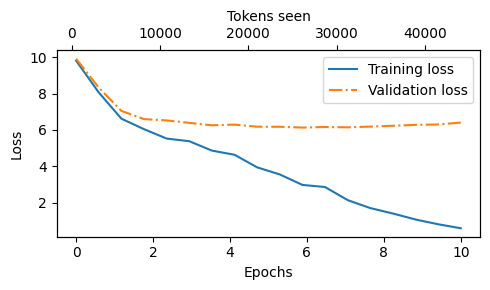

In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # 2nd x-axis that shares same y-axis
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Decoding strategies to control randomness

In [26]:
model.to("cpu")
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
# token_ids: (batch, n_tokens+50)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




### Temperature scaling

In [27]:
# Redo original approach 
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8 
}
inverse_vocab = {v:k for k,v in vocab.items()}
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])
probas = torch.softmax(next_token_logits, dim=0) # (vocab_len,)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [28]:
# Replace argmax with sample from a probability distribution => TORCH.MULTINOMIAL
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print("Next token id:", next_token_id)
# Select that word 1000 times
def print_sampled_tokens(probas):
    sample = [torch.multinomial(probas, num_samples=1).item()
              for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample)) # [<num_items_0>, <num_items_1>, ...]
    for i, freq  in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

Next token id: 3
73 x closer
0 x every
0 x effort
581 x forward
2 x inches
0 x moves
0 x pizza
344 x toward


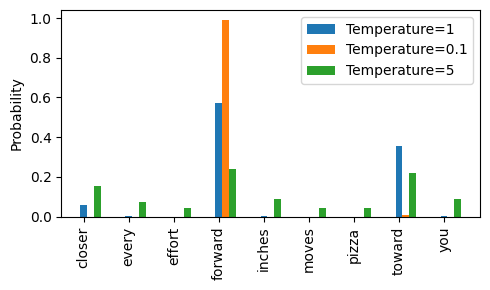

In [29]:
# Temperature scaling
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits/temperature
    return torch.softmax(scaled_logits, dim=0)
temperatures = [1, 0.1, 5]
# <next_token_logits>: (vocab_len,)
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures] # list of (vocab_len,) each
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x+i*bar_width, scaled_probas[i], bar_width, label=f"Temperature={T}")
ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()


## Top-k sampling

In [30]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k) # (3,) and (3,)
print("Top logits:", top_logits)
print("Top positions:", top_pos)


Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [31]:
# Set logits outside top-3 to -inf
new_logits = torch.where(
    condition = next_token_logits < top_logits[-1],
    input = torch.tensor(float('-inf')),
    other = next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [32]:
# probs of all entries in <vocab> (for the next token)
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [33]:
## Text generation with temperature scaling & top-k & multinomial-sampling
# idx: (batch,seq_len) with batch=1 for now
# eos_id: stop generating when we generate the char <eos_id>
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # crop if sentence too long
        with torch.no_grad():
            logits = model(idx_cond) # (1,seq_len,vocab_len)
        # take last token in predicted sequence
        logits = logits[:,-1,:] # (1,vocab_len)
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:,-1]
            # change outside-top3 logits to "-inf"
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        # temperature scaling
        if temperature > 0.0:
            logits = logits/temperature # (1,vocab_len)
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else: 
            idx_next = torch.argmax(logits, dim=-1, keepdim=True) # (1,1)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1) # (batch,seq_len+1)
    return idx # (batch, seq_len+num_new_tokens)
            
        

In [34]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print(token_ids.shape)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

torch.Size([1, 19])
Output text:
 Every effort moves you can," was one of the, one of lo that point across the enough


## Loading and saving model weights in Pytorch


In [35]:
# Save model
torch.save(model.state_dict(), "model.pth")

In [36]:
# Load model
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [37]:
# Save both model weights and optimizer
torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }, "model_and_optimizer.pth"
)

In [38]:
# Load both model weights and optimizer
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## Loading pretrained weights from OpenAI